<a href="https://colab.research.google.com/github/ARKAL-J04/MachineLearning2025/blob/main/MachineLearning2025%20/Final%20Project/AI_Proj_Arshia_Kalantarian_40121993.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import


In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import pickle
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import time

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


In [ ]:
# ==============================================================================
# Cell 2: Download and Load Dataset (Final, Most Robust Version)
# ==============================================================================
# این نسخه ابتدا محتویات پوشه را نمایش می‌دهد و سپس به صورت خودکار اولین فایل CSV
# که پیدا کند را بارگذاری می‌کند. این روش بسیار قابل اعتماد است.


print("Downloading dataset from Kaggle Hub...")
# 1. دانلود دیتاست و گرفتن مسیر پوشه آن
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
print(f"Kaggle Hub returned path: {path}\n")

# 2. ✨ نمایش محتویات پوشه برای بررسی دستی ✨
print("---Inspecting directory contents---")
# از یک دستور سیستمی برای نمایش فایل‌ها استفاده می‌کنیم
# این به ما کمک می‌کند بفهمیم ساختار فایل‌ها چگونه است
try:
    # این دستور تمام فایل‌ها و زیرپوشه‌ها را لیست می‌کند
    os.system(f'ls -R "{path}"')
except Exception as e:
    print(f"Could not list directory contents: {e}")
print("---------------------------------")


# 3. ✨ جستجوی هوشمند برای هر فایل CSV ✨
print("\nSearching for any .csv file...")
correct_csv_path = None
# در مسیر داده شده می‌گردیم
for root, dirs, files in os.walk(path):
    # تمام فایل‌ها در پوشه فعلی را بررسی می‌کنیم
    for file_name in files:
        # اگر فایل پسوند .csv داشت، خودشه!
        if file_name.endswith(".csv"):
            # مسیر کامل آن را می‌سازیم
            correct_csv_path = os.path.join(root, file_name)
            print(f"Found CSV file: {file_name}")
            break  # از حلقه داخلی خارج می‌شویم
    if correct_csv_path:
        break # از حلقه خارجی هم خارج می‌شویم

# 4. خواندن دیتاست با استفاده از مسیر پیدا شده
if correct_csv_path:
    print(f"✅ Attempting to load: {correct_csv_path}")
    try:
        df = pd.read_csv(correct_csv_path)
        print("✅ Dataset loaded successfully.")
        print("Dataset shape:", df.shape)
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
    except Exception as e:
        print(f"❌ Error reading the CSV file: {e}")
else:
    print(f"❌ Error: Could not automatically find any .csv file inside the directory: {path}")


Using Colab cache for faster access to the 'fake-news-classification' dataset.
Kaggle Hub returned path: /kaggle/input/fake-news-classification

---Inspecting directory contents---
---------------------------------

Searching for any .csv file...
Found CSV file: WELFake_Dataset.csv
✅ Attempting to load: /kaggle/input/fake-news-classification/WELFake_Dataset.csv
✅ Dataset loaded successfully.
Dataset shape: (72134, 4)

First 5 rows of the dataset:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they p

# HashingVectorizer



In [ ]:
# ==============================================================================
# 🚀 راه‌حل نهایی: پردازش تکه‌ای (Batch Processing) برای دیتاست‌های عظیم 🚀
# ==============================================================================
# این کد جایگزین سلول‌های ۳، ۴ و ۵ شما می‌شود.
# این روش فایل را تکه به تکه می‌خواند و هرگز کل دیتاست را در حافظه بارگذاری نمی‌کند.

# فراموش نکنید که این کتابخانه‌ها را در سلول اول import کنید:
# from sklearn.linear_model import SGDClassifier
# from sklearn.feature_extraction.text import HashingVectorizer
# import numpy as np

# 1. تعریف Vectorizer و Model
# از HashingVectorizer استفاده می‌کنیم چون نیازی به دیدن تمام داده‌ها از قبل ندارد.
vectorizer = HashingVectorizer(stop_words='english', n_features=5000)

# از SGDClassifier استفاده می‌کنیم چون از partial_fit پشتیبانی می‌کند.
# این مدل می‌تواند به صورت تدریجی یاد بگیرد.
model = SGDClassifier(max_iter=1000)

# 2. خواندن و پردازش فایل به صورت تکه‌ای در یک حلقه
print("\nStarting batch processing (out-of-core learning)...")

# مسیر فایل CSV خود را که از سلول دوم به دست آمده، اینجا قرار دهید
# من فرض می‌کنم متغیر correct_csv_path از سلول قبل در دسترس است

# ✨ اضافه کردن مرحله برای تعیین کلاس‌ها از یک نمونه کوچک ✨
try:
    # خواندن فقط چند سطر اول برای تعیین کلاس‌ها
    sample_df = pd.read_csv(correct_csv_path, nrows=100)
    # حذف مقادیر NaN در این نمونه کوچک قبل از پیدا کردن کلاس‌ها
    sample_df.dropna(inplace=True)
    # پیدا کردن تمام کلاس‌های منحصر به فرد در ستون 'label'
    classes = np.unique(sample_df['label'])
    print(f"Determined unique classes from sample: {classes}")
except Exception as e:
    print(f"❌ Error determining classes from sample: {e}")
    # در صورت بروز خطا، از کلاس‌های پیش‌فرض استفاده می‌کنیم اما ممکن است دوباره خطا دهد
    classes = np.array(['FAKE', 'REAL'])
    print(f"Using default classes due to error: {classes}")

chunk_iterator = pd.read_csv(correct_csv_path, chunksize=5000) # هر بار ۵۰۰۰ سطر می‌خواند


# شماره بچ فعلی را برای نمایش نگه می‌داریم
batch_num = 1

# حالا در میان تکه‌ها (chunks) حلقه می‌زنیم
for chunk in chunk_iterator:
    print(f"Processing Batch #{batch_num}...")

    # 2.1. پیش‌پردازش بچ فعلی
    chunk.dropna(inplace=True)
    X_chunk = chunk['text']
    y_chunk = chunk['label']

    # اطمینان حاصل می‌کنیم که بچ خالی نیست
    if len(X_chunk) == 0:
        print(f"Batch #{batch_num} is empty after dropping NaNs, skipping...")
        batch_num += 1
        continue

    # 2.2. تبدیل متن بچ فعلی به بردار
    # اطمینان حاصل می‌کنیم که داده ورودی به vectorizer رشته باشد
    X_chunk_vectorized = vectorizer.transform(X_chunk.values.astype('U'))

    # 2.3. آموزش تدریجی مدل با بچ فعلی
    # در اولین بچ، باید لیست تمام کلاس‌های ممکن را به مدل بدهیم
    # از متغیر classes که از نمونه اولیه به دست آوردیم استفاده می‌کنیم.
    # partial_fit در بچ‌های بعدی نیازی به classes= ندارد مگر اینکه کلاس جدیدی ظاهر شود
    # اما در این دیتاست مشخص، کلاس‌ها ثابت هستند (0 و 1).
    if batch_num == 1:
         model.partial_fit(X_chunk_vectorized, y_chunk, classes=classes)
    else:
         model.partial_fit(X_chunk_vectorized, y_chunk)


    batch_num += 1

print("\n✅ Model training complete through batch processing.")

# حالا مدل شما بدون کرش کردن رم، روی کل دیتاست آموزش دیده است!
# می‌توانید در سلول‌های بعدی آن را ارزیابی یا ذخیره کنید.
# برای ارزیابی، باید داده تست را هم به صورت تکه‌ای بخوانید و پیش‌بینی کنید.
# اما برای سادگی، فعلاً روی آموزش تمرکز کردیم.


Starting batch processing (out-of-core learning)...
Determined unique classes from sample: [0 1]
Processing Batch #1...
Processing Batch #2...
Processing Batch #3...
Processing Batch #4...
Processing Batch #5...
Processing Batch #6...
Processing Batch #7...
Processing Batch #8...
Processing Batch #9...
Processing Batch #10...
Processing Batch #11...
Processing Batch #12...
Processing Batch #13...
Processing Batch #14...
Processing Batch #15...

✅ Model training complete through batch processing.


In [ ]:
# ==============================================================================
# Cell: Evaluate the Batch-Trained Model
# ==============================================================================
# در این سلول، عملکرد مدل آموزش‌دیده را به صورت تکه‌ای ارزیابی می‌کنیم.

print("\nStarting evaluation of the trained model...")

# 1. متغیرهایی برای نگهداری نتایج نهایی
total_samples = 0
correct_predictions = 0
# لیست‌هایی برای ذخیره تمام برچسب‌های واقعی و پیش‌بینی شده
# برای اینکه در انتها بتوانیم گزارش کامل را بسازیم
y_true_all = []
y_pred_all = []

# 2. دوباره یک ایتریتور تکه‌ای روی فایل CSV ایجاد می‌کنیم
# این کار حافظه را پر نمی‌کند
chunk_iterator_eval = pd.read_csv(correct_csv_path, chunksize=5000)
batch_num = 1

# 3. حلقه برای ارزیابی تکه به تکه
for chunk in chunk_iterator_eval:
    print(f"Evaluating Batch #{batch_num}...")

    # 3.1. پیش‌پردازش بچ فعلی
    chunk.dropna(inplace=True)
    X_chunk_eval = chunk['text']
    y_chunk_eval = chunk['label']

    if len(X_chunk_eval) == 0:
        print(f"Batch #{batch_num} is empty, skipping...")
        batch_num += 1
        continue

    # 3.2. تبدیل متن با استفاده از همان وکتورایزر
    # مهم: اینجا فقط از transform استفاده می‌کنیم، نه fit_transform
    X_chunk_vectorized_eval = vectorizer.transform(X_chunk_eval.values.astype('U'))

    # 3.3. پیش‌بینی با مدل آموزش‌دیده
    y_pred_chunk = model.predict(X_chunk_vectorized_eval)

    # 3.4. جمع‌آوری نتایج
    correct_predictions += np.sum(y_pred_chunk == y_chunk_eval)
    total_samples += len(y_chunk_eval)
    y_true_all.extend(y_chunk_eval)
    y_pred_all.extend(y_pred_chunk)

    batch_num += 1

# 4. محاسبه و نمایش نتایج نهایی
print("\n✅ Evaluation complete.")

if total_samples > 0:
    # محاسبه دقت کلی
    accuracy = correct_predictions / total_samples
    print(f"\nOverall Model Accuracy: {accuracy * 100:.2f}%")

    # نمایش ماتریس درهم‌ریختگی و گزارش کامل
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))

    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))
else:
    print("No samples were evaluated. The dataset might be empty.")



Starting evaluation of the trained model...
Evaluating Batch #1...
Evaluating Batch #2...
Evaluating Batch #3...
Evaluating Batch #4...
Evaluating Batch #5...
Evaluating Batch #6...
Evaluating Batch #7...
Evaluating Batch #8...
Evaluating Batch #9...
Evaluating Batch #10...
Evaluating Batch #11...
Evaluating Batch #12...
Evaluating Batch #13...
Evaluating Batch #14...
Evaluating Batch #15...

✅ Evaluation complete.

Overall Model Accuracy: 92.81%

Confusion Matrix:
[[31835  3193]
 [ 1952 34557]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     35028
           1       0.92      0.95      0.93     36509

    accuracy                           0.93     71537
   macro avg       0.93      0.93      0.93     71537
weighted avg       0.93      0.93      0.93     71537



#Logistic regression Method

In [ ]:
# ==============================================================================
# Cell: Train with Multiple Models (Selectable)
# ==============================================================================
# در این سلول می‌توانید به راحتی مدل مورد نظر خود را انتخاب و آموزش دهید.
# فقط کافیست مدل دلخواه را از حالت کامنت خارج کرده و بقیه را کامنت نگه دارید.


# 1. ✨ بخش انتخاب مدل ✨
# ------------------------------------------------------------------------------
# مدل مورد نظر خود را از حالت کامنت خارج کنید (علامت # را از ابتدای آن بردارید)

# مدل ۱: رگرسیون لجستیک (پیاده‌سازی شده با SGD) - سریع و کارآمد
model_name = "Logistic Regression (via SGD)"
model = SGDClassifier(loss='log_loss', max_iter=1000)

# مدل ۲: پرسپترون چندلایه (شبکه عصبی) - ممکن است کندتر باشد اما پتانسیل دقت بالاتری دارد
# model_name = "MLP Classifier (Neural Network)"
# model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True)

# مدل ۳: Multinomial Naive Bayes - یک مدل کلاسیک و سریع برای متن
# model_name = "Multinomial Naive Bayes"
# model = MultinomialNB()
# ------------------------------------------------------------------------------

# از HashingVectorizer که قبلاً تعریف شده استفاده می‌کنیم
vectorizer = HashingVectorizer(stop_words='english', n_features=5000)

print(f"\n===== Training Model: {model_name} =====")

# 2. خواندن و پردازش فایل به صورت تکه‌ای
chunk_iterator = pd.read_csv(correct_csv_path, chunksize=5000)

# تعیین کلاس‌ها از یک نمونه کوچک (این کد از قبل وجود داشت و عالی است)
sample_df = pd.read_csv(correct_csv_path, nrows=100)
sample_df.dropna(inplace=True)
classes = np.unique(sample_df['label'])
print(f"Determined classes: {classes}")

batch_num = 1
for chunk in chunk_iterator:
    print(f"Processing Batch #{batch_num} for {model_name}...")

    chunk.dropna(inplace=True)
    X_chunk = chunk['text']
    y_chunk = chunk['label']

    if len(X_chunk) == 0:
        batch_num += 1
        continue

    X_chunk_vectorized = vectorizer.transform(X_chunk.values.astype('U'))

    # آموزش تدریجی با مدل انتخاب شده
    # نکته بهینه‌سازی: مدل فقط در اولین بچ نیاز به دیدن لیست کامل کلاس‌ها دارد.
    if batch_num == 1:
        model.partial_fit(X_chunk_vectorized, y_chunk, classes=classes)
    else:
        model.partial_fit(X_chunk_vectorized, y_chunk)

    batch_num += 1

print(f"\n✅ Model '{model_name}' training complete.")

# حالا می‌توانید سلول ارزیابی را برای این مدل جدید اجرا کنید و نتایج را ببینید!


===== Training Model: Logistic Regression (via SGD) =====
Determined classes: [0 1]
Processing Batch #1 for Logistic Regression (via SGD)...
Processing Batch #2 for Logistic Regression (via SGD)...
Processing Batch #3 for Logistic Regression (via SGD)...
Processing Batch #4 for Logistic Regression (via SGD)...
Processing Batch #5 for Logistic Regression (via SGD)...
Processing Batch #6 for Logistic Regression (via SGD)...
Processing Batch #7 for Logistic Regression (via SGD)...
Processing Batch #8 for Logistic Regression (via SGD)...
Processing Batch #9 for Logistic Regression (via SGD)...
Processing Batch #10 for Logistic Regression (via SGD)...
Processing Batch #11 for Logistic Regression (via SGD)...
Processing Batch #12 for Logistic Regression (via SGD)...
Processing Batch #13 for Logistic Regression (via SGD)...
Processing Batch #14 for Logistic Regression (via SGD)...
Processing Batch #15 for Logistic Regression (via SGD)...

✅ Model 'Logistic Regression (via SGD)' training comp

In [ ]:
# ==============================================================================
# Cell: Evaluate the Batch-Trained Model
# ==============================================================================
# در این سلول، عملکرد مدل آموزش‌دیده را به صورت تکه‌ای ارزیابی می‌کنیم.

print("\nStarting evaluation of the trained model...")

# 1. متغیرهایی برای نگهداری نتایج نهایی
total_samples = 0
correct_predictions = 0
# لیست‌هایی برای ذخیره تمام برچسب‌های واقعی و پیش‌بینی شده
# برای اینکه در انتها بتوانیم گزارش کامل را بسازیم
y_true_all = []
y_pred_all = []

# 2. دوباره یک ایتریتور تکه‌ای روی فایل CSV ایجاد می‌کنیم
# این کار حافظه را پر نمی‌کند
chunk_iterator_eval = pd.read_csv(correct_csv_path, chunksize=5000)
batch_num = 1

# 3. حلقه برای ارزیابی تکه به تکه
for chunk in chunk_iterator_eval:
    print(f"Evaluating Batch #{batch_num}...")

    # 3.1. پیش‌پردازش بچ فعلی
    chunk.dropna(inplace=True)
    X_chunk_eval = chunk['text']
    y_chunk_eval = chunk['label']

    if len(X_chunk_eval) == 0:
        print(f"Batch #{batch_num} is empty, skipping...")
        batch_num += 1
        continue

    # 3.2. تبدیل متن با استفاده از همان وکتورایزر
    # مهم: اینجا فقط از transform استفاده می‌کنیم، نه fit_transform
    X_chunk_vectorized_eval = vectorizer.transform(X_chunk_eval.values.astype('U'))

    # 3.3. پیش‌بینی با مدل آموزش‌دیده
    y_pred_chunk = model.predict(X_chunk_vectorized_eval)

    # 3.4. جمع‌آوری نتایج
    correct_predictions += np.sum(y_pred_chunk == y_chunk_eval)
    total_samples += len(y_chunk_eval)
    y_true_all.extend(y_chunk_eval)
    y_pred_all.extend(y_pred_chunk)

    batch_num += 1

# 4. محاسبه و نمایش نتایج نهایی
print("\n✅ Evaluation complete.")

if total_samples > 0:
    # محاسبه دقت کلی
    accuracy = correct_predictions / total_samples
    print(f"\nOverall Model Accuracy: {accuracy * 100:.2f}%")

    # نمایش ماتریس درهم‌ریختگی و گزارش کامل
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))

    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))
else:
    print("No samples were evaluated. The dataset might be empty.")



Starting evaluation of the trained model...
Evaluating Batch #1...
Evaluating Batch #2...
Evaluating Batch #3...
Evaluating Batch #4...
Evaluating Batch #5...
Evaluating Batch #6...
Evaluating Batch #7...
Evaluating Batch #8...
Evaluating Batch #9...
Evaluating Batch #10...
Evaluating Batch #11...
Evaluating Batch #12...
Evaluating Batch #13...
Evaluating Batch #14...
Evaluating Batch #15...

✅ Evaluation complete.

Overall Model Accuracy: 91.06%

Confusion Matrix:
[[31319  3709]
 [ 2688 33821]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     35028
           1       0.90      0.93      0.91     36509

    accuracy                           0.91     71537
   macro avg       0.91      0.91      0.91     71537
weighted avg       0.91      0.91      0.91     71537



## Testing

In [ ]:
# ==============================================================================
# Cell: Final Prediction with Confidence Score (using Logistic Regression)
# ==============================================================================
# در این سلول، مدل رگرسیون لجستیک (دومین مدل برتر ما) را که قابلیت ارائه
# درصد اطمینان را دارد، آموزش داده، ذخیره و برای پیش‌بینی نهایی استفاده می‌کنیم.



# --- 1. آموزش و ذخیره‌سازی مدل رگرسیون لجستیک ---
# ------------------------------------------------------------------------------
print("--- Phase 1: Training and Saving the Logistic Regression model ---")

# تعریف Vectorizer و Model
vectorizer_lg = HashingVectorizer(stop_words='english', n_features=5000)
# ✨ نکته کلیدی: استفاده از SGDClassifier با loss='log_loss'
model_lg = SGDClassifier(loss='log_loss', max_iter=1000)
model_name = "Logistic Regression"

# فرآیند آموزش تکه‌ای (کد از قبل آماده است)
try:
    chunk_iterator = pd.read_csv(correct_csv_path, chunksize=5000)
    classes = np.array([0, 1])
    batch_num = 1
    for chunk in chunk_iterator:
        print(f"Training Batch #{batch_num} for {model_name}...")
        chunk.dropna(inplace=True)
        X_chunk, y_chunk = chunk['text'], chunk['label']
        if len(X_chunk) == 0:
            batch_num += 1
            continue
        X_chunk_vectorized = vectorizer_lg.transform(X_chunk.values.astype('U'))
        model_lg.partial_fit(X_chunk_vectorized, y_chunk, classes=classes)
        batch_num += 1
    print(f"\n✅ {model_name} model trained successfully.")

    # ذخیره کردن مدل و وکتورایزر
    with open('logistic_model.pkl', 'wb') as f:
        pickle.dump(model_lg, f)
    with open('logistic_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer_lg, f)
    print("✅ Logistic Regression model and vectorizer saved.")

except NameError:
    print("❌ Error: 'correct_csv_path' not found. Please run the data loading cell first.")
    exit()


# --- 2. بارگذاری و پیش‌بینی با درصد اطمینان ---
# ------------------------------------------------------------------------------
print("\n--- Phase 2: Loading model and predicting new text ---")
with open('logistic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('logistic_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# --- 3. تابع پیش‌بینی (حالا با درصد اطمینان) ---
# ------------------------------------------------------------------------------
def predict_news_with_confidence(text):
    print("\n-----------------------------------------")
    print(f"📰 Analyzing news text:\n'{text[:150]}...'")

    vectorized_text = loaded_vectorizer.transform([text])
    prediction_code = loaded_model.predict(vectorized_text)[0]
    prediction_proba = loaded_model.predict_proba(vectorized_text)[0]

    if prediction_code == 0:
        result = "خبر واقعی ✅"
        confidence = prediction_proba[0] * 100
    else:
        result = "خبر جعلی ❌"
        confidence = prediction_proba[1] * 100

    print(f"\n🕵️‍♂️ Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%") # ✨ حالا درصد اطمینان نمایش داده می‌شود!
    print("-----------------------------------------")

# --- 4. آزمایش مدل ---
# ------------------------------------------------------------------------------
news_text_1 = """
Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
The Republican candidate’s 2024 campaign team said the massive haul came from small-dollar donors.
"""

news_text_2 = """
Scientists announced today the discovery of a new planet in our solar system made entirely of diamond.
The planet, named 'Xylos', is reportedly being towed towards Earth by an advanced alien civilization to solve our economic problems.
"""

predict_news_with_confidence(news_text_1)
predict_news_with_confidence(news_text_2)


--- Phase 1: Training and Saving the Logistic Regression model ---
Training Batch #1 for Logistic Regression...
Training Batch #2 for Logistic Regression...
Training Batch #3 for Logistic Regression...
Training Batch #4 for Logistic Regression...
Training Batch #5 for Logistic Regression...
Training Batch #6 for Logistic Regression...
Training Batch #7 for Logistic Regression...
Training Batch #8 for Logistic Regression...
Training Batch #9 for Logistic Regression...
Training Batch #10 for Logistic Regression...
Training Batch #11 for Logistic Regression...
Training Batch #12 for Logistic Regression...
Training Batch #13 for Logistic Regression...
Training Batch #14 for Logistic Regression...
Training Batch #15 for Logistic Regression...

✅ Logistic Regression model trained successfully.
✅ Logistic Regression model and vectorizer saved.

--- Phase 2: Loading model and predicting new text ---

-----------------------------------------
📰 Analyzing news text:
'
Donald Trump’s campaign say

#Neural Network


In [ ]:
# 1. ✨ بخش انتخاب مدل ✨
# ------------------------------------------------------------------------------
# مدل مورد نظر خود را از حالت کامنت خارج کنید (علامت # را از ابتدای آن بردارید)

# مدل ۱: رگرسیون لجستیک (پیاده‌سازی شده با SGD) - سریع و کارآمد
#model_name = "Logistic Regression (via SGD)"
#model = SGDClassifier(loss='log_loss', max_iter=1000)

# مدل ۲: پرسپترون چندلایه (شبکه عصبی) - ممکن است کندتر باشد اما پتانسیل دقت بالاتری دارد
model_name = "MLP Classifier (Neural Network)"
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True)

# مدل ۳: Multinomial Naive Bayes - یک مدل کلاسیک و سریع برای متن
# model_name = "Multinomial Naive Bayes"
# model = MultinomialNB()
# ------------------------------------------------------------------------------

# از HashingVectorizer که قبلاً تعریف شده استفاده می‌کنیم
vectorizer = HashingVectorizer(stop_words='english', n_features=5000)

print(f"\n===== Training Model: {model_name} =====")

# 2. خواندن و پردازش فایل به صورت تکه‌ای
chunk_iterator = pd.read_csv(correct_csv_path, chunksize=5000)

# تعیین کلاس‌ها از یک نمونه کوچک (این کد از قبل وجود داشت و عالی است)
sample_df = pd.read_csv(correct_csv_path, nrows=100)
sample_df.dropna(inplace=True)
classes = np.unique(sample_df['label'])
print(f"Determined classes: {classes}")

batch_num = 1
for chunk in chunk_iterator:
    print(f"Processing Batch #{batch_num} for {model_name}...")

    chunk.dropna(inplace=True)
    X_chunk = chunk['text']
    y_chunk = chunk['label']

    if len(X_chunk) == 0:
        batch_num += 1
        continue

    X_chunk_vectorized = vectorizer.transform(X_chunk.values.astype('U'))

    # آموزش تدریجی با مدل انتخاب شده
    # نکته بهینه‌سازی: مدل فقط در اولین بچ نیاز به دیدن لیست کامل کلاس‌ها دارد.
    if batch_num == 1:
        model.partial_fit(X_chunk_vectorized, y_chunk, classes=classes)
    else:
        model.partial_fit(X_chunk_vectorized, y_chunk)

    batch_num += 1

print(f"\n✅ Model '{model_name}' training complete.")

# حالا می‌توانید سلول ارزیابی را برای این مدل جدید اجرا کنید و نتایج را ببینید!


===== Training Model: MLP Classifier (Neural Network) =====
Determined classes: [0 1]
Processing Batch #1 for MLP Classifier (Neural Network)...
Processing Batch #2 for MLP Classifier (Neural Network)...
Processing Batch #3 for MLP Classifier (Neural Network)...
Processing Batch #4 for MLP Classifier (Neural Network)...
Processing Batch #5 for MLP Classifier (Neural Network)...
Processing Batch #6 for MLP Classifier (Neural Network)...
Processing Batch #7 for MLP Classifier (Neural Network)...
Processing Batch #8 for MLP Classifier (Neural Network)...
Processing Batch #9 for MLP Classifier (Neural Network)...
Processing Batch #10 for MLP Classifier (Neural Network)...
Processing Batch #11 for MLP Classifier (Neural Network)...
Processing Batch #12 for MLP Classifier (Neural Network)...
Processing Batch #13 for MLP Classifier (Neural Network)...
Processing Batch #14 for MLP Classifier (Neural Network)...
Processing Batch #15 for MLP Classifier (Neural Network)...

✅ Model 'MLP Classifi

In [ ]:
# ==============================================================================
# Cell: Evaluate the Batch-Trained Model
# ==============================================================================
# در این سلول، عملکرد مدل آموزش‌دیده را به صورت تکه‌ای ارزیابی می‌کنیم.

print("\nStarting evaluation of the trained model...")

# 1. متغیرهایی برای نگهداری نتایج نهایی
total_samples = 0
correct_predictions = 0
# لیست‌هایی برای ذخیره تمام برچسب‌های واقعی و پیش‌بینی شده
# برای اینکه در انتها بتوانیم گزارش کامل را بسازیم
y_true_all = []
y_pred_all = []

# 2. دوباره یک ایتریتور تکه‌ای روی فایل CSV ایجاد می‌کنیم
# این کار حافظه را پر نمی‌کند
chunk_iterator_eval = pd.read_csv(correct_csv_path, chunksize=5000)
batch_num = 1

# 3. حلقه برای ارزیابی تکه به تکه
for chunk in chunk_iterator_eval:
    print(f"Evaluating Batch #{batch_num}...")

    # 3.1. پیش‌پردازش بچ فعلی
    chunk.dropna(inplace=True)
    X_chunk_eval = chunk['text']
    y_chunk_eval = chunk['label']

    if len(X_chunk_eval) == 0:
        print(f"Batch #{batch_num} is empty, skipping...")
        batch_num += 1
        continue

    # 3.2. تبدیل متن با استفاده از همان وکتورایزر
    # مهم: اینجا فقط از transform استفاده می‌کنیم، نه fit_transform
    X_chunk_vectorized_eval = vectorizer.transform(X_chunk_eval.values.astype('U'))

    # 3.3. پیش‌بینی با مدل آموزش‌دیده
    y_pred_chunk = model.predict(X_chunk_vectorized_eval)

    # 3.4. جمع‌آوری نتایج
    correct_predictions += np.sum(y_pred_chunk == y_chunk_eval)
    total_samples += len(y_chunk_eval)
    y_true_all.extend(y_chunk_eval)
    y_pred_all.extend(y_pred_chunk)

    batch_num += 1

# 4. محاسبه و نمایش نتایج نهایی
print("\n✅ Evaluation complete.")

if total_samples > 0:
    # محاسبه دقت کلی
    accuracy = correct_predictions / total_samples
    print(f"\nOverall Model Accuracy: {accuracy * 100:.2f}%")

    # نمایش ماتریس درهم‌ریختگی و گزارش کامل
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))

    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))
else:
    print("No samples were evaluated. The dataset might be empty.")



Starting evaluation of the trained model...
Evaluating Batch #1...
Evaluating Batch #2...
Evaluating Batch #3...
Evaluating Batch #4...
Evaluating Batch #5...
Evaluating Batch #6...
Evaluating Batch #7...
Evaluating Batch #8...
Evaluating Batch #9...
Evaluating Batch #10...
Evaluating Batch #11...
Evaluating Batch #12...
Evaluating Batch #13...
Evaluating Batch #14...
Evaluating Batch #15...

✅ Evaluation complete.

Overall Model Accuracy: 93.37%

Confusion Matrix:
[[32381  2647]
 [ 2093 34416]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     35028
           1       0.93      0.94      0.94     36509

    accuracy                           0.93     71537
   macro avg       0.93      0.93      0.93     71537
weighted avg       0.93      0.93      0.93     71537



## Testing

In [ ]:
# ==============================================================================
# Cell: Save the Best Model AND Predict with it (Corrected Version)
# ==============================================================================
# این نسخه اصلاح‌شده از نام‌های عمومی model و vectorizer استفاده می‌کند
# تا با خروجی سلول آموزش شما هماهنگ باشد.

# --- 1. ذخیره کردن مدل و وکتورایزر فعال در حافظه ---
# ------------------------------------------------------------------------------
# این بخش حالا به دنبال متغیرهای عمومی 'model' و 'vectorizer' می‌گردد
model_filename = 'best_model.pkl'
vectorizer_filename = 'vectorizer.pkl'

print(f"--- Phase 1: Saving the currently active model ({model_name}) ---")
try:
    # ✨ تغییر اصلی اینجاست: استفاده از 'model' به جای 'model_nn'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    # ✨ تغییر اصلی اینجاست: استفاده از 'vectorizer' به جای 'vectorizer_nn'
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(vectorizer, f)

    print(f"✅ Model saved as '{model_filename}'")
    print(f"✅ Vectorizer saved as '{vectorizer_filename}'")
except NameError:
    print("❌ Error: Could not find 'model' or 'vectorizer' in memory.")
    print("Please re-run the main training cell first, then run this cell again.")
    # Removed exit()
except Exception as e:
    print(f"An unexpected error occurred during saving: {e}")
    # Removed exit()

# --- 2. بارگذاری و استفاده از مدل ذخیره‌شده (این بخش بدون تغییر است) ---
# ------------------------------------------------------------------------------
print("\n--- Phase 2: Loading model and predicting new text ---")

try:
    with open(model_filename, 'rb') as f:
        loaded_model = pickle.load(f)

    with open(vectorizer_filename, 'rb') as f:
        loaded_vectorizer = pickle.load(f)
    print("✅ Model and vectorizer loaded successfully for prediction.")


    # --- 3. تابع پیش‌بینی (بدون تغییر) ---
    # ------------------------------------------------------------------------------
    def predict_news(text):
        print("\n-----------------------------------------")
        print(f"📰 Analyzing news text:\n'{text[:150]}...'")

        vectorized_text = loaded_vectorizer.transform([text])
        prediction_code = loaded_model.predict(vectorized_text)[0]

        # ✨ Added check for predict_proba
        if hasattr(loaded_model, 'predict_proba'):
            prediction_proba = loaded_model.predict_proba(vectorized_text)[0]
            # فرض می‌کنیم کلاس 0 برای "واقعی" و کلاس 1 برای "جعلی" است
            # این را بر اساس خروجی Determined classes: [0 1] می‌دانیم
            if prediction_code == 0:
                result = "خبر واقعی ✅"
                confidence = prediction_proba[0] * 100
            else:
                result = "خبر جعلی ❌"
                confidence = prediction_proba[1] * 100
            print(f"\n🕵️‍♂️ Prediction: {result}")
            print(f"Confidence: {confidence:.2f}%")
        else:
            # Handle models that don't have predict_proba
            result = "خبر واقعی ✅" if prediction_code == 0 else "خبر جعلی ❌"
            print(f"\n🕵️‍♂️ Prediction: {result}")
            print("Confidence: N/A (Model does not provide probability estimates)")
        # ✨ End of added check

        print("-----------------------------------------")

    # --- 4. آزمایش مدل با خبرهای جدید (بدون تغییر) ---
    # ------------------------------------------------------------------------------
    news_text_1 = """
    Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
    The Republican candidate’s 2024 campaign team said the massive haul came from small-dollar donors.
    """



    news_text_2 = """
    A team of scientists has discovered a new species of flying elephant in the Amazon rainforest.
    These elephants, which have large, feathery wings, can reportedly fly for hundreds of miles without landing.
    The discovery has shocked the scientific community, with many calling it the most significant biological find of the century.
    """

    predict_news(news_text_1)
    predict_news(news_text_2)

except FileNotFoundError:
    print("❌ Error: Could not find saved model or vectorizer files.")
    print("Please make sure you have run the cell that saves the best model first.")
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")

--- Phase 1: Saving the currently active model (MLP Classifier (Neural Network)) ---
✅ Model saved as 'best_model.pkl'
✅ Vectorizer saved as 'vectorizer.pkl'

--- Phase 2: Loading model and predicting new text ---
✅ Model and vectorizer loaded successfully for prediction.

-----------------------------------------
📰 Analyzing news text:
'
    Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
    The Republican candidate’s 20...'

🕵️‍♂️ Prediction: خبر جعلی ❌
Confidence: 50.25%
-----------------------------------------

-----------------------------------------
📰 Analyzing news text:
'
    A team of scientists has discovered a new species of flying elephant in the Amazon rainforest.
    These elephants, which have large, feathery wi...'

🕵️‍♂️ Prediction: خبر جعلی ❌
Confidence: 92.31%
-----------------------------------------


# Multinomial Naive Bayes Method



In [ ]:
# ==============================================================================
# Cell: Naive Bayes Method (with TF-IDF) - Training and Evaluation
# ==============================================================================
# این سلول مدل Naive Bayes را با TF-IDF به صورت بهینه آموزش و ارزیابی می‌کند.

# فراموش نکنید این را در سلول اول import کنید:
# from sklearn.feature_extraction.text import TfidfVectorizer


start_time = time.time()

# 1. تعریف Vectorizer و Model
# ------------------------------------------------------------------------------
print("===== Starting Multinomial Naive Bayes Experiment =====")
model_name = "Multinomial Naive Bayes"

# ✨ تغییر اصلی اینجاست: استفاده از TF-IDF به جای Hashing
# ما آن را با max_features محدود می‌کنیم تا در زمان fit کردن حافظه را پر نکند.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, max_features=5000)

# تعریف مدل Naive Bayes
model_nb = MultinomialNB()


# 2. بخش Fit کردن Vectorizer (یک مرحله جدید و مهم)
# ------------------------------------------------------------------------------
# TF-IDF باید ابتدا روی بخشی از داده‌ها fit شود تا دیکشنری کلمات خود را بسازد.
print("\n--- Phase 1: Fitting the TF-IDF Vectorizer on a sample ---")
# ما فقط روی ۵ بچ اول (۲۵۰۰۰ سطر) آن را فیت می‌کنیم که برای ساخت دیکشنری کافی است.
chunk_iterator_fit = pd.read_csv(correct_csv_path, chunksize=5000)
sample_texts = []
for i, chunk in enumerate(chunk_iterator_fit):
    chunk.dropna(inplace=True)
    sample_texts.extend(chunk['text'].values.astype('U'))
    if i > 3: # (0, 1, 2, 3, 4) -> 5 chunks
        break

tfidf_vectorizer.fit(sample_texts)
print("✅ TF-IDF Vectorizer has been fitted successfully.")
del sample_texts # آزاد کردن حافظه


# 3. بخش آموزش (Training Phase)
# ------------------------------------------------------------------------------
print(f"\n--- Phase 2: Training {model_name} ---")

chunk_iterator_train = pd.read_csv(correct_csv_path, chunksize=5000)
classes = np.array([0, 1]) # ما از قبل می‌دانیم کلاس‌ها 0 و 1 هستند

batch_num = 1
for chunk in chunk_iterator_train:
    print(f"Training Batch #{batch_num}...")
    chunk.dropna(inplace=True)
    X_chunk = chunk['text']
    y_chunk = chunk['label']

    if len(X_chunk) == 0:
        batch_num += 1
        continue

    # حالا از وکتورایزر fit شده فقط برای transform استفاده می‌کنیم
    X_chunk_vectorized = tfidf_vectorizer.transform(X_chunk.values.astype('U'))
    model_nb.partial_fit(X_chunk_vectorized, y_chunk, classes=classes)
    batch_num += 1

print(f"\n✅ Model '{model_name}' training complete.")


# 4. بخش ارزیابی (Evaluation Phase)
# ------------------------------------------------------------------------------
print(f"\n--- Phase 3: Evaluating {model_name} ---")
# ... (کد ارزیابی دقیقاً مثل قبل است، فقط متغیرها را تغییر می‌دهیم)
total_samples, correct_predictions = 0, 0
y_true_all, y_pred_all = [], []
chunk_iterator_eval = pd.read_csv(correct_csv_path, chunksize=5000)
batch_num = 1
for chunk in chunk_iterator_eval:
    print(f"Evaluating Batch #{batch_num}...")
    chunk.dropna(inplace=True)
    X_chunk_eval = chunk['text']
    y_chunk_eval = chunk['label']
    if len(X_chunk_eval) == 0:
        batch_num += 1
        continue
    X_chunk_vectorized_eval = tfidf_vectorizer.transform(X_chunk_eval.values.astype('U'))
    y_pred_chunk = model_nb.predict(X_chunk_vectorized_eval)
    correct_predictions += np.sum(y_pred_chunk == y_chunk_eval)
    total_samples += len(y_chunk_eval)
    y_true_all.extend(y_chunk_eval)
    y_pred_all.extend(y_pred_chunk)
    batch_num += 1

# 5. نمایش نتایج نهایی
# ------------------------------------------------------------------------------
print("\n✅ Evaluation complete.")
end_time = time.time()
elapsed_time = end_time - start_time
if total_samples > 0:
    accuracy = correct_predictions / total_samples
    print(f"\n--- Performance of '{model_name}' ---")
    print(f"Total time taken: {elapsed_time:.2f} seconds")
    print(f"Overall Model Accuracy: {accuracy * 100:.2f}%")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, zero_division=0))
else:
    print("No samples were evaluated.")


===== Starting Multinomial Naive Bayes Experiment =====

--- Phase 1: Fitting the TF-IDF Vectorizer on a sample ---
✅ TF-IDF Vectorizer has been fitted successfully.

--- Phase 2: Training Multinomial Naive Bayes ---
Training Batch #1...
Training Batch #2...
Training Batch #3...
Training Batch #4...
Training Batch #5...
Training Batch #6...
Training Batch #7...
Training Batch #8...
Training Batch #9...
Training Batch #10...
Training Batch #11...
Training Batch #12...
Training Batch #13...
Training Batch #14...
Training Batch #15...

✅ Model 'Multinomial Naive Bayes' training complete.

--- Phase 3: Evaluating Multinomial Naive Bayes ---
Evaluating Batch #1...
Evaluating Batch #2...
Evaluating Batch #3...
Evaluating Batch #4...
Evaluating Batch #5...
Evaluating Batch #6...
Evaluating Batch #7...
Evaluating Batch #8...
Evaluating Batch #9...
Evaluating Batch #10...
Evaluating Batch #11...
Evaluating Batch #12...
Evaluating Batch #13...
Evaluating Batch #14...
Evaluating Batch #15...

✅ E

## Testing

In [ ]:
# ==============================================================================
# Cell: Final Prediction with Confidence (using Naive Bayes)
# ==============================================================================
# این سلول مدل Naive Bayes را ذخیره کرده و سپس از آن برای پیش‌بینی نهایی
# روی خبرهای جدید همراه با درصد اطمینان استفاده می‌کند.


# --- 1. ذخیره کردن مدل Naive Bayes و TF-IDF Vectorizer ---
# ------------------------------------------------------------------------------
# فرض بر این است که متغیرهای model_nb و tfidf_vectorizer از سلول آموزش
# Naive Bayes هنوز در حافظه Colab موجود هستند.
model_filename = 'naive_bayes_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'

print("--- Phase 1: Saving the Naive Bayes model and TF-IDF vectorizer ---")
try:
    # ✨ ذخیره کردن مدل Naive Bayes
    with open(model_filename, 'wb') as f:
        pickle.dump(model_nb, f)

    # ✨ ذخیره کردن TF-IDF Vectorizer
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    print(f"✅ Model saved as '{model_filename}'")
    print(f"✅ Vectorizer saved as '{vectorizer_filename}'")
except NameError:
    print("❌ Error: Could not find 'model_nb' or 'tfidf_vectorizer' in memory.")
    print("Please re-run the cell that trains the 'Naive Bayes' model first, then run this cell again.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during saving: {e}")
    exit()

# --- 2. بارگذاری و استفاده از مدل ذخیره‌شده ---
# ------------------------------------------------------------------------------
print("\n--- Phase 2: Loading model and predicting new text ---")
try:
    with open(model_filename, 'rb') as f:
        loaded_model = pickle.load(f)
    with open(vectorizer_filename, 'rb') as f:
        loaded_vectorizer = pickle.load(f)
    print("✅ Model and vectorizer loaded successfully for prediction.")
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()


# --- 3. تابع پیش‌بینی (با درصد اطمینان) ---
# ------------------------------------------------------------------------------
def predict_news_nb(text):
    print("\n-----------------------------------------")
    print(f"📰 Analyzing news text:\n'{text[:150]}...'")

    vectorized_text = loaded_vectorizer.transform([text])
    prediction_code = loaded_model.predict(vectorized_text)[0]
    prediction_proba = loaded_model.predict_proba(vectorized_text)[0]

    if prediction_code == 0:
        result = "خبر واقعی ✅"
        confidence = prediction_proba[0] * 100
    else:
        result = "خبر جعلی ❌"
        confidence = prediction_proba[1] * 100

    print(f"\n🕵️‍♂️ Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")
    print("-----------------------------------------")

# --- 4. آزمایش مدل (با همان خبرهای قبلی برای مقایسه) ---
# ------------------------------------------------------------------------------
news_text_1 = """
Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
The Republican candidate’s 2024 campaign team said the massive haul came from small-dollar donors.
"""

news_text_2 = """
Scientists announced today the discovery of a new planet in our solar system made entirely of diamond.
The planet, named 'Xylos', is reportedly being towed towards Earth by an advanced alien civilization.
"""

predict_news_nb(news_text_1)
predict_news_nb(news_text_2)


--- Phase 1: Saving the Naive Bayes model and TF-IDF vectorizer ---
✅ Model saved as 'naive_bayes_model.pkl'
✅ Vectorizer saved as 'tfidf_vectorizer.pkl'

--- Phase 2: Loading model and predicting new text ---
✅ Model and vectorizer loaded successfully for prediction.

-----------------------------------------
📰 Analyzing news text:
'
Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
The Republican candidate’s 2024 campa...'

🕵️‍♂️ Prediction: خبر واقعی ✅
Confidence: 52.94%
-----------------------------------------

-----------------------------------------
📰 Analyzing news text:
'
Scientists announced today the discovery of a new planet in our solar system made entirely of diamond.
The planet, named 'Xylos', is reportedly being...'

🕵️‍♂️ Prediction: خبر جعلی ❌
Confidence: 87.99%
-----------------------------------------


# Fuzzy Logic

In [ ]:
!pip install -U scikit-fuzzy

نمودار توابع عضویت برای متغیر ورودی 'confidence':


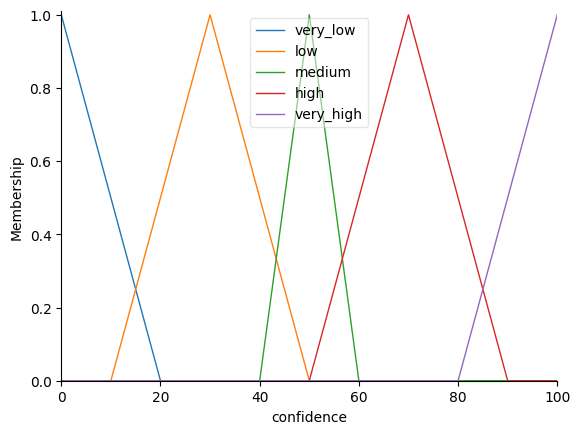


نمودار توابع عضویت برای متغیر خروجی 'verdict':


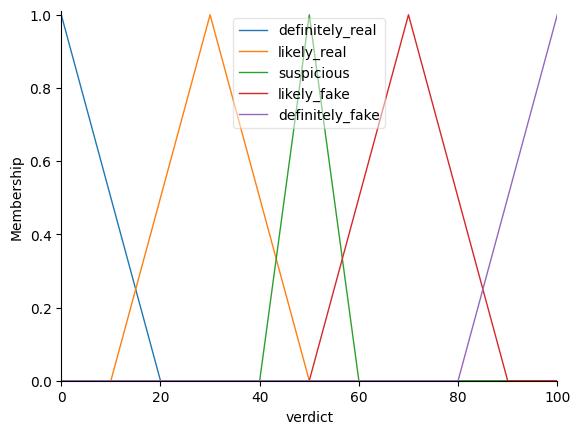

In [ ]:
# ==============================================================================
# Cell: Visualize the Fuzzy Membership Functions
# ==============================================================================
# این سلول به صورت اختصاصی برای تعریف و نمایش نمودار توابع عضویت فازی
# برای ورودی (confidence) و خروجی (verdict) طراحی شده است.

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt # برای نمایش بهتر نمودارها

# --- ۱. تعریف مجدد متغیرها و توابع عضویت ---
# این کد تکرار همان تعاریفی است که در سلول اصلی داشتیم

# ورودی: درصد اطمینان از جعلی بودن
confidence = ctrl.Antecedent(np.arange(0, 101, 1), 'confidence')

# خروجی: وضعیت نهایی خبر
verdict = ctrl.Consequent(np.arange(0, 101, 1), 'verdict')

# تعریف توابع عضویت برای ورودی (اطمینان)
confidence['very_low'] = fuzz.trimf(confidence.universe, [0, 0, 20])
confidence['low'] = fuzz.trimf(confidence.universe, [10, 30, 50])
confidence['medium'] = fuzz.trimf(confidence.universe, [40, 50, 60])
confidence['high'] = fuzz.trimf(confidence.universe, [50, 70, 90])
confidence['very_high'] = fuzz.trimf(confidence.universe, [80, 100, 100])

# تعریف توابع عضویت برای خروجی (وضعیت)
verdict['definitely_real'] = fuzz.trimf(verdict.universe, [0, 0, 20])
verdict['likely_real'] = fuzz.trimf(verdict.universe, [10, 30, 50])
verdict['suspicious'] = fuzz.trimf(verdict.universe, [40, 50, 60])
verdict['likely_fake'] = fuzz.trimf(verdict.universe, [50, 70, 90])
verdict['definitely_fake'] = fuzz.trimf(verdict.universe, [80, 100, 100])


# --- ۲. نمایش نمودارها ---
# حالا که متغیرها در همین سلول تعریف شده‌اند، این دستورات بدون خطا کار می‌کنند

print("نمودار توابع عضویت برای متغیر ورودی 'confidence':")
confidence.view()
plt.show() # برای نمایش بهتر در Colab

print("\nنمودار توابع عضویت برای متغیر خروجی 'verdict':")
verdict.view()
plt.show() # برای نمایش بهتر در Colab


In [ ]:
# ==============================================================================
# Cell: The Complete News Analysis System (ML Model + Fuzzy Logic) - Final Version
# ==============================================================================
# این نسخه اصلاح‌شده، بخش پیش‌بینی را فقط در صورت موفقیت‌آمیز بودن بارگذاری مدل اجرا می‌کند.

import pickle
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd # اضافه شد برای خواندن دیتاست در صورت نیاز

# --- بخش ۱: بارگذاری مدل یادگیری ماشین (تشخیص‌دهنده) ---
# ------------------------------------------------------------------------------
print("--- Loading the Machine Learning Detector (Logistic Regression) ---")
try:
    with open('logistic_model.pkl', 'rb') as f:
        ml_model = pickle.load(f)
    with open('logistic_vectorizer.pkl', 'rb') as f:
        ml_vectorizer = pickle.load(f)
    print("✅ ML Detector loaded successfully.")

    # ✨ تغییر اصلی: تمام کدهای بعدی داخل این try قرار می‌گیرند ✨

    # --- بخش ۲: ساخت سیستم فازی (تفسیرکننده) ---
    print("\n--- Building the Fuzzy Logic Interpreter ---")
    confidence = ctrl.Antecedent(np.arange(0, 101, 1), 'confidence')
    verdict = ctrl.Consequent(np.arange(0, 101, 1), 'verdict')
    # ... (بقیه تعریفات فازی بدون تغییر)
    confidence['very_low'] = fuzz.trimf(confidence.universe, [0, 0, 20])
    confidence['low'] = fuzz.trimf(confidence.universe, [10, 30, 50])
    confidence['medium'] = fuzz.trimf(confidence.universe, [40, 50, 60])
    confidence['high'] = fuzz.trimf(confidence.universe, [50, 70, 90])
    confidence['very_high'] = fuzz.trimf(confidence.universe, [80, 100, 100])
    verdict['definitely_real'] = fuzz.trimf(verdict.universe, [0, 0, 20])
    verdict['likely_real'] = fuzz.trimf(verdict.universe, [10, 30, 50])
    verdict['suspicious'] = fuzz.trimf(verdict.universe, [40, 50, 60])
    verdict['likely_fake'] = fuzz.trimf(verdict.universe, [50, 70, 90])
    verdict['definitely_fake'] = fuzz.trimf(verdict.universe, [80, 100, 100])
    rule1 = ctrl.Rule(confidence['very_low'], verdict['definitely_real'])
    rule2 = ctrl.Rule(confidence['low'], verdict['likely_real'])
    rule3 = ctrl.Rule(confidence['medium'], verdict['suspicious'])
    rule4 = ctrl.Rule(confidence['high'], verdict['likely_fake'])
    rule5 = ctrl.Rule(confidence['very_high'], verdict['definitely_fake'])
    news_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
    news_analyzer = ctrl.ControlSystemSimulation(news_ctrl)
    print("✅ Fuzzy Interpreter is ready.")

    # --- بخش ۳: تابع نهایی خط تولید ---
    def analyze_full_story(news_text):
        print("\n==============================================")
        print(f"📰 Analyzing new story:\n'{news_text[:150]}...'")
        print("----------------------------------------------")
        print("Step 1: Getting confidence score from ML model...")
        vectorized_text = ml_vectorizer.transform([news_text])
        confidence_fake = ml_model.predict_proba(vectorized_text)[0][1] * 100
        print(f"-> ML model confidence (that it's FAKE): {confidence_fake:.2f}%")
        print("\nStep 2: Interpreting the score with Fuzzy Logic...")
        news_analyzer.input['confidence'] = confidence_fake
        news_analyzer.compute()
        output_score = news_analyzer.output['verdict']
        if output_score <= 25:
            verdict_label = "قطعا واقعی"
        elif output_score <= 45:
            verdict_label = "احتمالا واقعی"
        elif output_score <= 55:
            verdict_label = "مشکوک"
        elif output_score <= 75:
            verdict_label = "احتمالا جعلی"
        else:
            verdict_label = "قطعا جعلی"
        print(f"-> Fuzzy system output score: {output_score:.2f}")
        print("\n----------------------------------------------")
        print(f"✅ FINAL VERDICT: {verdict_label}")
        print("==============================================")

    # --- آزمایش سیستم کامل ---
    news_text_real = """
    Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
    """
    news_text_fake = """
    Scientists announced today the discovery of a new planet in our solar system made entirely of diamond.
    """
    analyze_full_story(news_text_real)
    analyze_full_story(news_text_fake)

except FileNotFoundError:
    print("\n❌ Error: Could not find 'logistic_model.pkl' or 'logistic_vectorizer.pkl'.")
    print("👉 Please re-run the cell that TRAINS AND SAVES the Logistic Regression model first.")



--- Loading the Machine Learning Detector (Logistic Regression) ---
✅ ML Detector loaded successfully.

--- Building the Fuzzy Logic Interpreter ---
✅ Fuzzy Interpreter is ready.

📰 Analyzing new story:
'
    Donald Trump’s campaign says it has raised $50.5m online since his historic conviction in his hush-money trial.
    ...'
----------------------------------------------
Step 1: Getting confidence score from ML model...
-> ML model confidence (that it's FAKE): 80.03%

Step 2: Interpreting the score with Fuzzy Logic...
-> Fuzzy system output score: 70.02

----------------------------------------------
✅ FINAL VERDICT: احتمالا جعلی

📰 Analyzing new story:
'
    Scientists announced today the discovery of a new planet in our solar system made entirely of diamond.
    ...'
----------------------------------------------
Step 1: Getting confidence score from ML model...
-> ML model confidence (that it's FAKE): 90.75%

Step 2: Interpreting the score with Fuzzy Logic...
-> Fuzzy system outp